# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Первая лабораторная работа </center>


В данной работе Вы познакомитесь с основными методами работы с аудиоданными в Python. Разбересь в том, как работает свертка, и примените пару интересных фильтров.

# Задание 1. Работа с аудиофайлами в Python (1 балл)

## Теория

Звук - это аналоговый сигнал. То есть он является непрерывным по времени и по значениям. Для того, чтобы работать со звуком на цифровом устройстве, надо преобразовать его в цифровое представление. Для этого надо разделить непрерывный сигнал на промежутки времени (дискретизация сигнала) и разбить непрерывные значения на интервалы (квантование сигнала). Выбраные параметры дискретизации и квантования сигнала напрямую влияют на качество цифрового сигнала. 

<!-- 
## Практика

1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла? 

2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?   

3. Чем .wav отличается от других кодеков, например .mp3 или .ogg? -->


<!-- ### Подсказка

Записать цифровой сигнал можно при помощи, например, [Audacity](https://www.audacityteam.org) или [Adobe Audition](https://www.adobe.com/ru/products/audition.html). Для считывания файлов воспользуйтесь библиотекой [scipy](https://www.scipy.org) или [librosa](https://librosa.org/doc/latest/index.html). Для воспроизведения аудиофайла удобно использовать класс Audio из модуля IPython.display, а для отрисовки - matplotlib. -->

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline

import wave
import struct

In [2]:

!pip install --user librosa

### 1. Что хранится в .wav файле? Как узнать параметры дискретизации и квантования .wav файла?

In [3]:
#В файле wav хранятся: RIFF заголовок 12 байт, информация о формате, аудиоданные (звук, кодированный числами).
import struct

def quick_wav_info(filename):
    """информация о WAV файле с примерами заголовков и чанков"""
    
    with open(filename, 'rb') as f:
        # RIFF header - заголовок (12 байт)
        riff = f.read(12)
        chunk_id, chunk_size, format = struct.unpack('<4sI4s', riff)
        
        print("ПРИМЕРЫ ЗАГОЛОВКОВ И ЧАНКОВ")
        print(f"Файл: {filename}")
        print("\n1. RIFF ЗАГОЛОВОК (12 байт):")
        print(f"   Hex: {riff.hex()}")
        print(f"   Chunk ID: {chunk_id.decode('ascii')}")
        print(f"   Chunk Size: {chunk_size} байт")
        print(f"   Format: {format.decode('ascii')}")
        
        # Сохраняем позицию для возврата
        current_pos = f.tell()
        
        print("\n2. ПРОСМОТР ВСЕХ CHUNK'ОВ:")
        
        # Возвращаемся к началу chunks
        f.seek(12)
        chunk_num = 1
        
        while True:
            chunk_start = f.tell()
            chunk_header = f.read(8)
            if not chunk_header or len(chunk_header) < 8:
                break
                
            subchunk_id, subchunk_size = struct.unpack('<4sI', chunk_header)
            
            print(f"\n   Chunk #{chunk_num}:")
            print(f"   Позиция: {chunk_start}-{chunk_start + 8 + subchunk_size}")
            print(f"   Header Hex: {chunk_header.hex()}")
            print(f"   Chunk ID: {subchunk_id} -> '{subchunk_id.decode('ascii', errors='replace')}'")
            print(f"   Chunk Size: {subchunk_size} байт")
            
            # Читаем немного данных из chunk'а для примера
            if subchunk_size > 0:
                data_sample = f.read(min(16, subchunk_size))  # Читаем первые 16 байт данных
                print(f"   Data Sample (первые 16 байт): {data_sample.hex()}")
                
                # Если это fmt chunk, разбираем его подробно
                if subchunk_id == b'fmt ':
                    print(f"   --- FMT CHUNK ДЕТАЛИ ---")
                    fmt_data = data_sample
                    if len(fmt_data) >= 16:
                        audio_format, channels, sr, byte_rate, block_align, bits = struct.unpack('<HHIIHH', fmt_data[:16])
                        print(f"   Audio Format: {audio_format} {'(PCM)' if audio_format == 1 else ''}")
                        print(f"   Channels: {channels}")
                        print(f"   Sample Rate: {sr} Hz")
                        print(f"   Byte Rate: {byte_rate} байт/сек")
                        print(f"   Block Align: {block_align} байт")
                        print(f"   Bits per Sample: {bits} бит")
                
                # Пропускаем оставшиеся данные chunk'а
                remaining_size = subchunk_size - len(data_sample)
                if remaining_size > 0:
                    f.seek(remaining_size, 1)
            else:
                print(f"   Data: (пустой chunk)")
            
            chunk_num += 1
            
            # Если нашли data chunk, выходим после него
            if subchunk_id == b'data':
                print(f"\n   --- DATA CHUNK ИНФОРМАЦИЯ ---")
                print(f"   Это основной аудиоданные (звук)")
                print(f"   Всего сэмплов: ~{subchunk_size // block_align}")
                print(f"   Длительность: ~{subchunk_size / byte_rate:.2f} секунд")
                break
        
        # Возвращаемся для поиска fmt chunk
        f.seek(12)
        
        print("\n3. ПОДРОБНЫЙ АНАЛИЗ FMT CHUNK:")
        # Ищем fmt chunk - информация о формате
        while True:
            subchunk_id, subchunk_size = struct.unpack('<4sI', f.read(8))
            if subchunk_id == b'fmt ':
                fmt_data = f.read(subchunk_size)
                print(f"   Найден fmt chunk размером {subchunk_size} байт")
                print(f"   Данные fmt: {fmt_data.hex()}")
                
                if subchunk_size >= 16:
                    audio_format, channels, sr, byte_rate, block_align, bits = struct.unpack('<HHIIHH', fmt_data[:16])
                    
                break
            else:
                f.seek(subchunk_size, 1)




In [4]:
quick_wav_info('yavshitz_lab1.wav')

ПРИМЕРЫ ЗАГОЛОВКОВ И ЧАНКОВ
Файл: yavshitz_lab1.wav

1. RIFF ЗАГОЛОВОК (12 байт):
   Hex: 5249464690880e0057415645
   Chunk ID: RIFF
   Chunk Size: 952464 байт
   Format: WAVE

2. ПРОСМОТР ВСЕХ CHUNK'ОВ:

   Chunk #1:
   Позиция: 12-36
   Header Hex: 666d742010000000
   Chunk ID: b'fmt ' -> 'fmt '
   Chunk Size: 16 байт
   Data Sample (первые 16 байт): 0100020044ac000010b1020004001000
   --- FMT CHUNK ДЕТАЛИ ---
   Audio Format: 1 (PCM)
   Channels: 2
   Sample Rate: 44100 Hz
   Byte Rate: 176400 байт/сек
   Block Align: 4 байт
   Bits per Sample: 16 бит

   Chunk #2:
   Позиция: 36-952472
   Header Hex: 646174616c880e00
   Chunk ID: b'data' -> 'data'
   Chunk Size: 952428 байт
   Data Sample (первые 16 байт): 00000000000000000000000000000000

   --- DATA CHUNK ИНФОРМАЦИЯ ---
   Это основной аудиоданные (звук)
   Всего сэмплов: ~238107
   Длительность: ~5.40 секунд

3. ПОДРОБНЫЙ АНАЛИЗ FMT CHUNK:
   Найден fmt chunk размером 16 байт
   Данные fmt: 0100020044ac000010b1020004001000


### 2. Запишите аудиофайл со своим голосом. Загрузите его. Попробуйте поменять ему частоту дискретизации. Нарисуйте форму волны считанного файла. Воспроизведите полученные сигналы. При какой частоте дискретизации становится невозможно разобрать человеческую речь?

**Подсказка**

Записать цифровой сигнал можно при помощи, например, [Audacity](https://www.audacityteam.org) или [Adobe Audition](https://www.adobe.com/ru/products/audition.html). Для считывания файлов воспользуйтесь библиотекой [scipy](https://www.scipy.org) или [librosa](https://librosa.org/doc/latest/index.html). Для воспроизведения аудиофайла удобно использовать класс Audio из модуля IPython.display, а для отрисовки - matplotlib.

In [5]:
import librosa
from IPython.display import Audio, display
import librosa
import numpy as np
import soundfile as sf 
import matplotlib.pyplot as plt

In [6]:
#Загрузка файла
y, sr = librosa.load('yavshitz_lab1.wav', sr=None)

print("=== ОСНОВНАЯ ИНФОРМАЦИЯ ===")
print(f"Форма аудиоданных: {y.shape}")
print(f"Частота дискретизации: {sr} Hz")
print(f"Длительность: {len(y) / sr:.2f} секунд")
print(f"Диапазон амплитуд: [{y.min():.4f}, {y.max():.4f}]")


print("=== АНАЛИЗ ФОРМЫ (119054,) ===")
print(f"Форма данных: {y.shape}")
print(f"Тип данных: {type(y)}")
print(f"Тип массива: {y.dtype}")
print(f"Размерность: {y.ndim}D массив")


=== ОСНОВНАЯ ИНФОРМАЦИЯ ===
Форма аудиоданных: (238107,)
Частота дискретизации: 44100 Hz
Длительность: 5.40 секунд
Диапазон амплитуд: [-0.5374, 0.4407]
=== АНАЛИЗ ФОРМЫ (119054,) ===
Форма данных: (238107,)
Тип данных: <class 'numpy.ndarray'>
Тип массива: float32
Размерность: 1D массив


In [7]:
audio_path = 'yavshitz_lab1.wav'
y, sr = librosa.load(audio_path, sr=None)

Audio(audio_path)


In [8]:
print('ЧД = ', librosa.get_samplerate(audio_path))

ЧД =  44100


In [9]:
y_original, sr_original = librosa.load('yavshitz_lab1.wav', sr=None)
y_16k = librosa.resample(y_original, orig_sr=sr_original, target_sr=16000)
sr_16k = 16000

output_path_16k = 'yavshitz_lab1_16k.wav'
sf.write(output_path_16k, y_16k, sr_16k)
print(f"Файл сохранен как: {output_path_16k}")

y_16k_loaded, sr_16k_loaded = librosa.load(output_path_16k, sr=None)

Audio(output_path_16k)

Файл сохранен как: yavshitz_lab1_16k.wav


In [10]:
print('ЧД = ', librosa.get_samplerate(output_path_16k))

ЧД =  16000


Общий диапазон амплитуд: [-0.5863, 0.4896]


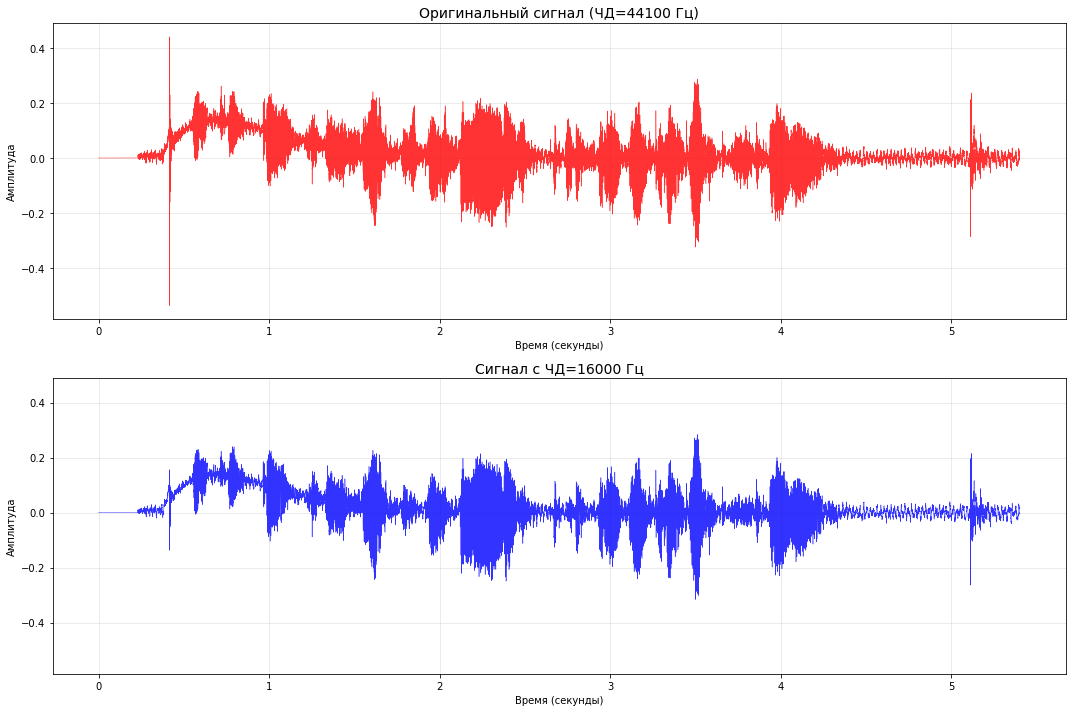

In [11]:
#График: оригинал и 16 кГц

y_original, sr_original = librosa.load('yavshitz_lab1.wav', sr=None)
y_16k, sr_16k = librosa.load('yavshitz_lab1_16k.wav', sr=None)

# Создаем временные оси
time_original = np.arange(len(y_original)) / sr_original
time_16k = np.arange(len(y_16k)) / sr_16k

# Находим общие пределы для вертикальной оси
y_min = min(y_original.min(), y_16k.min())
y_max = max(y_original.max(), y_16k.max())
# Добавляем небольшой запас для лучшего отображения
y_margin = (y_max - y_min) * 0.05
y_lim = (y_min - y_margin, y_max + y_margin)

print(f"Общий диапазон амплитуд: [{y_lim[0]:.4f}, {y_lim[1]:.4f}]")

# Сравнительная визуализация
plt.figure(figsize=(15, 10))

# Оригинальный сигнал
plt.subplot(2, 1, 1)
plt.plot(time_original, y_original, linewidth=0.5, alpha=0.8, color='red')
plt.title(f'Оригинальный сигнал (ЧД={sr_original} Гц)', fontsize=14)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)
plt.ylim(y_lim)  # Устанавливаем одинаковые пределы по Y

# Сигнал с ЧД=16000 Гц
plt.subplot(2, 1, 2)
plt.plot(time_16k, y_16k, linewidth=0.5, alpha=0.8, color='blue')
plt.title(f'Сигнал с ЧД=16000 Гц', fontsize=14)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)
plt.ylim(y_lim)  # Устанавливаем одинаковые пределы по Y

plt.tight_layout()
plt.show()

In [12]:
#ЧД=8000
y_8k = librosa.resample(y_original, orig_sr=sr_original, target_sr=8000)
sr_8k = 8000

output_path_8k = 'yavshitz_lab1_8k.wav'
sf.write(output_path_8k, y_8k, sr_8k)
print(f"Файл сохранен как: {output_path_8k}")

y_8k_loaded, sr_8k_loaded = librosa.load(output_path_8k, sr=None)

Audio(output_path_8k)

Файл сохранен как: yavshitz_lab1_8k.wav


In [13]:
print('ЧД = ', librosa.get_samplerate(output_path_8k))

ЧД =  8000


Общий диапазон амплитуд: [-0.5863, 0.4896]


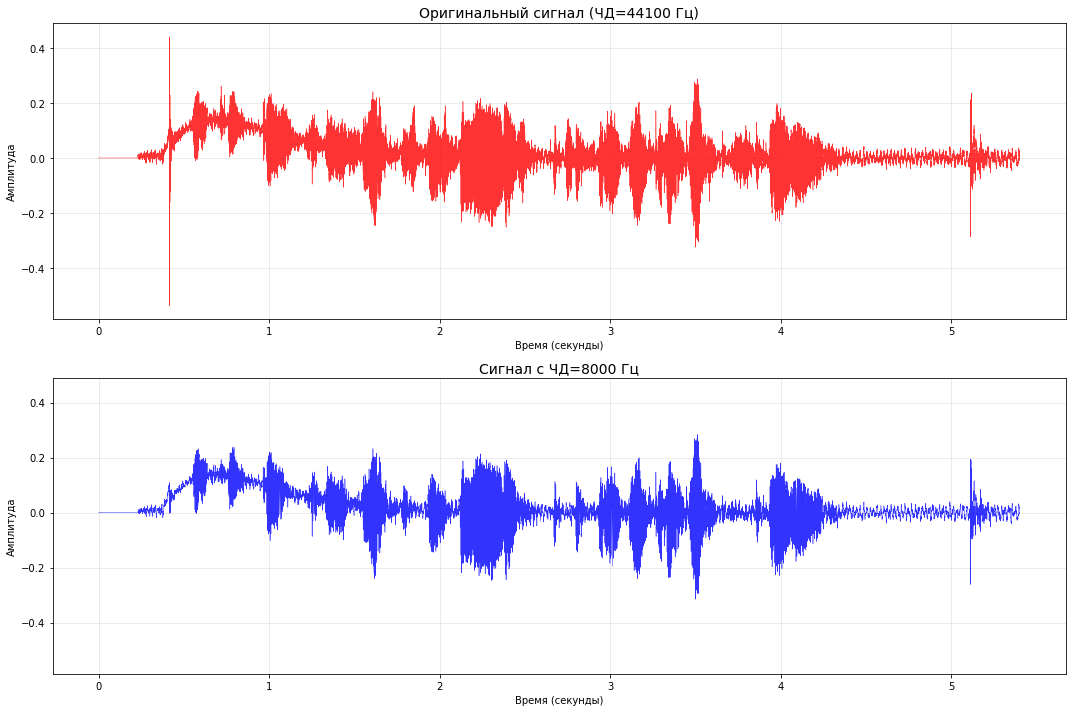

In [14]:
#График: оригинал и 8 кГЦ


# Загружаем оба файла для сравнения
y_original, sr_original = librosa.load('yavshitz_lab1.wav', sr=None)
y_8k, sr_8k = librosa.load('yavshitz_lab1_8k.wav', sr=None)

# Создаем временные оси
time_original = np.arange(len(y_original)) / sr_original
time_8k = np.arange(len(y_8k)) / sr_8k

# Находим общие пределы для вертикальной оси
y_min = min(y_original.min(), y_8k.min())
y_max = max(y_original.max(), y_8k.max())
# Добавляем небольшой запас для лучшего отображения
y_margin = (y_max - y_min) * 0.05
y_lim = (y_min - y_margin, y_max + y_margin)

print(f"Общий диапазон амплитуд: [{y_lim[0]:.4f}, {y_lim[1]:.4f}]")

# Сравнительная визуализация
plt.figure(figsize=(15, 10))

# Оригинальный сигнал
plt.subplot(2, 1, 1)
plt.plot(time_original, y_original, linewidth=0.5, alpha=0.8, color='red')
plt.title(f'Оригинальный сигнал (ЧД={sr_original} Гц)', fontsize=14)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)
plt.ylim(y_lim)  # Устанавливаем одинаковые пределы по Y

# Сигнал с ЧД=8000 Гц
plt.subplot(2, 1, 2)
plt.plot(time_8k, y_8k, linewidth=0.5, alpha=0.8, color='blue')
plt.title(f'Сигнал с ЧД=8000 Гц', fontsize=14)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)
plt.ylim(y_lim)  # Устанавливаем одинаковые пределы по Y

plt.tight_layout()
plt.show()

In [15]:
#ЧД=4000
y_4k = librosa.resample(y_original, orig_sr=sr_original, target_sr=4000)
sr_4k = 4000

output_path_4k = 'yavshitz_lab1_4k.wav'
sf.write(output_path_4k, y_4k, sr_4k)
print(f"Файл сохранен как: {output_path_4k}")

audio_path = 'yavshitz_lab1_4k.wav'
y_4k, sr = librosa.load(audio_path, sr=None)

Audio(output_path_4k)



Файл сохранен как: yavshitz_lab1_4k.wav


In [16]:
print('ЧД = ', librosa.get_samplerate(output_path_4k))

ЧД =  4000


In [17]:
#ЧД=2000

y_2k = librosa.resample(y_original, orig_sr=sr_original, target_sr=2000)
sr_2k = 2000

output_path_2k = 'yavshitz_lab1_2k.wav'
sf.write(output_path_2k, y_2k, sr_2k)
print(f"Файл сохранен как: {output_path_2k}")

Audio(output_path_2k)
#файл не воспроизводится

Файл сохранен как: yavshitz_lab1_2k.wav


In [18]:
print('ЧД = ', librosa.get_samplerate(output_path_2k))

ЧД =  2000


Общий диапазон амплитуд: [-0.5863, 0.4896]


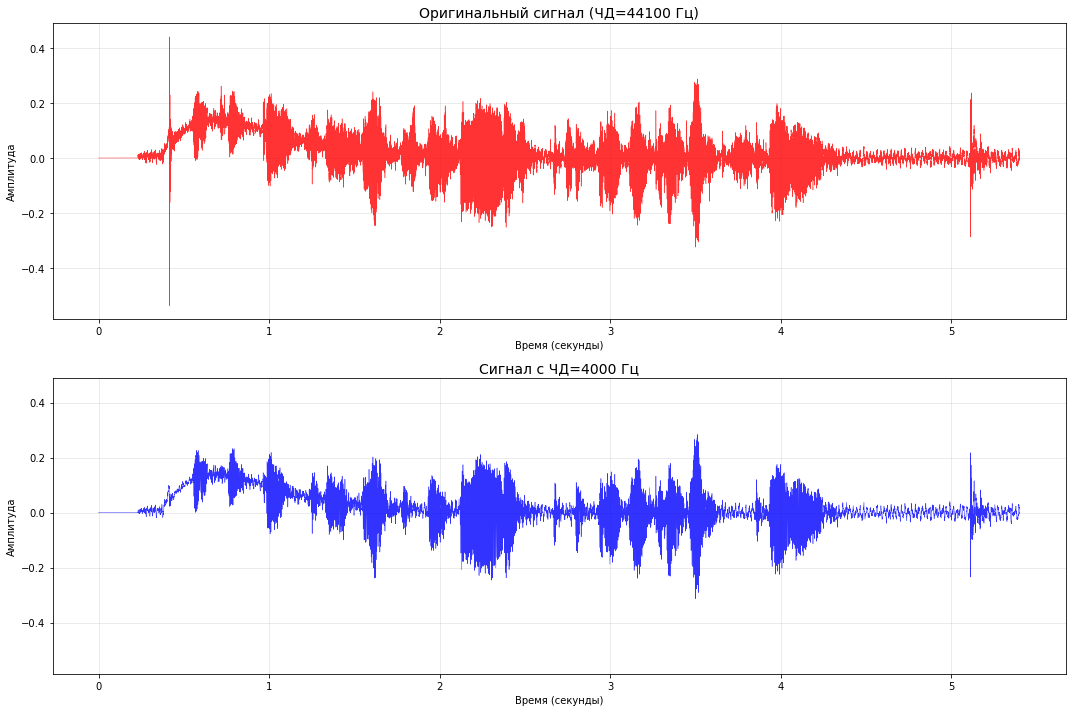

In [19]:
#График: оригинал и 4 кГц


# Загружаем оба файла для сравнения
y_original, sr_original = librosa.load('yavshitz_lab1.wav', sr=None)
y_4k, sr_4k = librosa.load('yavshitz_lab1_4k.wav', sr=None)

# Создаем временные оси
time_original = np.arange(len(y_original)) / sr_original
time_4k = np.arange(len(y_4k)) / sr_4k

# Находим общие пределы для вертикальной оси
y_min = min(y_original.min(), y_4k.min())
y_max = max(y_original.max(), y_4k.max())
# Добавляем небольшой запас для лучшего отображения
y_margin = (y_max - y_min) * 0.05
y_lim = (y_min - y_margin, y_max + y_margin)

print(f"Общий диапазон амплитуд: [{y_lim[0]:.4f}, {y_lim[1]:.4f}]")

# Сравнительная визуализация
plt.figure(figsize=(15, 10))

# Оригинальный сигнал
plt.subplot(2, 1, 1)
plt.plot(time_original, y_original, linewidth=0.5, alpha=0.8, color='red')
plt.title(f'Оригинальный сигнал (ЧД={sr_original} Гц)', fontsize=14)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)
plt.ylim(y_lim)  # Устанавливаем одинаковые пределы по Y

# Сигнал с ЧД=4000 Гц
plt.subplot(2, 1, 2)
plt.plot(time_4k, y_4k, linewidth=0.5, alpha=0.8, color='blue')
plt.title(f'Сигнал с ЧД=4000 Гц', fontsize=14)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.grid(True, alpha=0.3)
plt.ylim(y_lim)  # Устанавливаем одинаковые пределы по Y

plt.tight_layout()
plt.show()

На графиках с осциллограммой всего сигнала непонятно, чем передискретизовнный сигнал отличается от оригинала.
Возьмем масштаб по времени более детальный, чтобы было видно отсчеты.

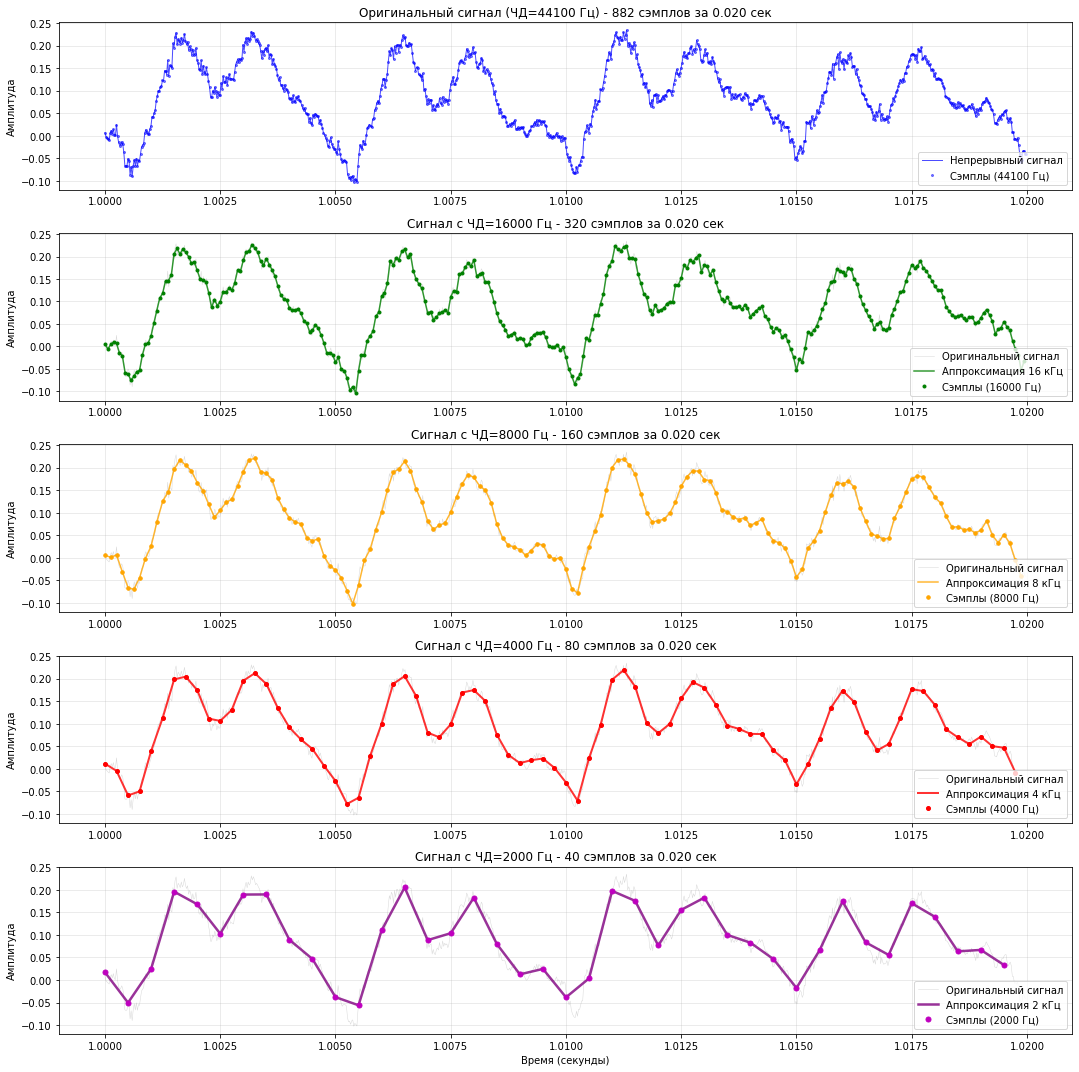

=== СТАТИСТИКА СЭМПЛОВ НА ФРАГМЕНТЕ ===
Временной интервал: 1.0-1.02 сек (0.020 секунд)
Оригинал (44100 Гц): 882 сэмплов
16 кГц: 320 сэмплов
8 кГц: 160 сэмплов
4 кГц: 80 сэмплов
2 кГц: 40 сэмплов

Отношение к оригиналу:
16 кГц: 0.363 (в 2.8 раз меньше)
8 кГц: 0.181 (в 5.5 раз меньше)
4 кГц: 0.091 (в 11.0 раз меньше)
2 кГц: 0.045 (в 22.1 раз меньше)


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import librosa

# Загружаем все файлы
y_original, sr_original = librosa.load('yavshitz_lab1.wav', sr=None)
y_16k, sr_16k = librosa.load('yavshitz_lab1_16k.wav', sr=None)
y_8k, sr_8k = librosa.load('yavshitz_lab1_8k.wav', sr=None)
y_4k, sr_4k = librosa.load('yavshitz_lab1_4k.wav', sr=None)
y_2k, sr_2k = librosa.load('yavshitz_lab1_2k.wav', sr=None)  

# Выбираем небольшой фрагмент для наглядности
start_time = 1.0
end_time = 1.02  # всего 0.02 секунды для ясности

# Вычисляем индексы для всех версий
start_idx_orig = int(start_time * sr_original)
end_idx_orig = int(end_time * sr_original)
start_idx_16k = int(start_time * sr_16k)
end_idx_16k = int(end_time * sr_16k)
start_idx_8k = int(start_time * sr_8k)
end_idx_8k = int(end_time * sr_8k)
start_idx_4k = int(start_time * sr_4k)
end_idx_4k = int(end_time * sr_4k)
start_idx_2k = int(start_time * sr_2k)  
end_idx_2k = int(end_time * sr_2k)

# Извлекаем фрагменты
y_orig_frag = y_original[start_idx_orig:end_idx_orig]
y_16k_frag = y_16k[start_idx_16k:end_idx_16k]
y_8k_frag = y_8k[start_idx_8k:end_idx_8k]
y_4k_frag = y_4k[start_idx_4k:end_idx_4k]
y_2k_frag = y_2k[start_idx_2k:end_idx_2k]  

# Временные оси для фрагментов
time_orig_frag = np.arange(len(y_orig_frag)) / sr_original + start_time
time_16k_frag = np.arange(len(y_16k_frag)) / sr_16k + start_time
time_8k_frag = np.arange(len(y_8k_frag)) / sr_8k + start_time
time_4k_frag = np.arange(len(y_4k_frag)) / sr_4k + start_time
time_2k_frag = np.arange(len(y_2k_frag)) / sr_2k + start_time  

# Визуализация с точками - все 5 версий
plt.figure(figsize=(15, 15))  

# Оригинал с высокой частотой
plt.subplot(5, 1, 1)
plt.plot(time_orig_frag, y_orig_frag, 'b-', linewidth=1, alpha=0.7, label='Непрерывный сигнал')
plt.plot(time_orig_frag, y_orig_frag, 'bo', markersize=2, alpha=0.5, label=f'Сэмплы ({sr_original} Гц)')
plt.title(f'Оригинальный сигнал (ЧД={sr_original} Гц) - {len(y_orig_frag)} сэмплов за {end_time-start_time:.3f} сек', fontsize=12)
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True, alpha=0.3)

# Сигнал 16 кГц
plt.subplot(5, 1, 2)
plt.plot(time_orig_frag, y_orig_frag, 'gray', linewidth=0.5, alpha=0.3, label='Оригинальный сигнал')
plt.plot(time_16k_frag, y_16k_frag, 'g-', linewidth=1.5, alpha=0.8, label='Аппроксимация 16 кГц')
plt.plot(time_16k_frag, y_16k_frag, 'go', markersize=3, label=f'Сэмплы ({sr_16k} Гц)')
plt.title(f'Сигнал с ЧД=16000 Гц - {len(y_16k_frag)} сэмплов за {end_time-start_time:.3f} сек', fontsize=12)
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True, alpha=0.3)

# Сигнал 8 кГц
plt.subplot(5, 1, 3)
plt.plot(time_orig_frag, y_orig_frag, 'gray', linewidth=0.5, alpha=0.3, label='Оригинальный сигнал')
plt.plot(time_8k_frag, y_8k_frag, 'orange', linewidth=1.5, alpha=0.8, label='Аппроксимация 8 кГц')
plt.plot(time_8k_frag, y_8k_frag, 'o', color='orange', markersize=3.5, label=f'Сэмплы ({sr_8k} Гц)')
plt.title(f'Сигнал с ЧД=8000 Гц - {len(y_8k_frag)} сэмплов за {end_time-start_time:.3f} сек', fontsize=12)
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True, alpha=0.3)

# Сигнал 4 кГц
plt.subplot(5, 1, 4)
plt.plot(time_orig_frag, y_orig_frag, 'gray', linewidth=0.5, alpha=0.3, label='Оригинальный сигнал')
plt.plot(time_4k_frag, y_4k_frag, 'r-', linewidth=2, alpha=0.8, label='Аппроксимация 4 кГц')
plt.plot(time_4k_frag, y_4k_frag, 'ro', markersize=4, label=f'Сэмплы ({sr_4k} Гц)')
plt.title(f'Сигнал с ЧД=4000 Гц - {len(y_4k_frag)} сэмплов за {end_time-start_time:.3f} сек', fontsize=12)
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True, alpha=0.3)

# Сигнал 2 кГц 
plt.subplot(5, 1, 5)
plt.plot(time_orig_frag, y_orig_frag, 'gray', linewidth=0.5, alpha=0.3, label='Оригинальный сигнал')
plt.plot(time_2k_frag, y_2k_frag, 'purple', linewidth=2.5, alpha=0.8, label='Аппроксимация 2 кГц')
plt.plot(time_2k_frag, y_2k_frag, 'mo', markersize=5, label=f'Сэмплы ({sr_2k} Гц)')
plt.title(f'Сигнал с ЧД=2000 Гц - {len(y_2k_frag)} сэмплов за {end_time-start_time:.3f} сек', fontsize=12)
plt.xlabel('Время (секунды)')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Вывод статистики
print("=== СТАТИСТИКА СЭМПЛОВ НА ФРАГМЕНТЕ ===")
print(f"Временной интервал: {start_time}-{end_time} сек ({end_time-start_time:.3f} секунд)")
print(f"Оригинал ({sr_original} Гц): {len(y_orig_frag)} сэмплов")
print(f"16 кГц: {len(y_16k_frag)} сэмплов")
print(f"8 кГц: {len(y_8k_frag)} сэмплов")
print(f"4 кГц: {len(y_4k_frag)} сэмплов")
print(f"2 кГц: {len(y_2k_frag)} сэмплов")  
print(f"\nОтношение к оригиналу:")
print(f"16 кГц: {len(y_16k_frag)/len(y_orig_frag):.3f} (в {len(y_orig_frag)/len(y_16k_frag):.1f} раз меньше)")
print(f"8 кГц: {len(y_8k_frag)/len(y_orig_frag):.3f} (в {len(y_orig_frag)/len(y_8k_frag):.1f} раз меньше)")
print(f"4 кГц: {len(y_4k_frag)/len(y_orig_frag):.3f} (в {len(y_orig_frag)/len(y_4k_frag):.1f} раз меньше)")
print(f"2 кГц: {len(y_2k_frag)/len(y_orig_frag):.3f} (в {len(y_orig_frag)/len(y_2k_frag):.1f} раз меньше)") 


### 3. Чем .wav отличается от других кодеков, например .mp3 или .ogg?

In [37]:
!pip install --user pydub
from pydub import AudioSegment
!pip install --user mutagen

In [38]:
# WAV to MP3
audio = AudioSegment.from_wav("yavshitz_lab1.wav")
audio.export("yavshitz_lab1.mp3", format="mp3")

<_io.BufferedRandom name='yavshitz_lab1.mp3'>

In [40]:
# WAV to OGG
audio = AudioSegment.from_wav("yavshitz_lab1.wav")
audio.export("yavshitz_lab1.ogg", format="ogg")

<_io.BufferedRandom name='yavshitz_lab1.ogg'>

wav - формат звука без сжатия, в отличие от mp3 и ogg. Сравним оригинальный файл и получившиеся в результате конвертации

In [41]:
# Размер файла
import os
wav_size = os.path.getsize('yavshitz_lab1.wav')
mp3_size = os.path.getsize('yavshitz_lab1.mp3') 
ogg_size = os.path.getsize('yavshitz_lab1.ogg')
print(f"WAV: {wav_size/1024/1024:.1f} MB")
print(f"MP3: {mp3_size/1024/1024:.1f} MB") 
print(f"OGG: {ogg_size/1024/1024:.1f} MB")

WAV: 0.9 MB
MP3: 0.1 MB
OGG: 0.1 MB


In [42]:
compression_ratio_mp3 = wav_size / mp3_size
compression_ratio_mp3

10.924347387255127

In [43]:
compression_ratio_ogg = wav_size / ogg_size
compression_ratio_ogg

11.749919814463004

В wav информации в 9 раз больше, чем в mp3 и ogg, но и памяти он занимает больше.

In [48]:
# Вычисление количества частотных компонентов
y_wav, sr_wav = librosa.load('yavshitz_lab1.wav')
y_mp3, sr_mp3 = librosa.load('yavshitz_lab1.mp3')
y_ogg, sr_ogg = librosa.load('yavshitz_lab1.ogg')

freqs_wav = len(librosa.stft(y_wav))
freqs_mp3 = len(librosa.stft(y_mp3))
freqs_ogg = len(librosa.stft(y_ogg))

print(f"WAV: {freqs_wav} частотных компонентов")
print(f"MP3: {freqs_mp3} частотных компонентов") 
print(f"OGG: {freqs_ogg} частотных компонентов")

WAV: 1025 частотных компонентов
MP3: 1025 частотных компонентов
OGG: 1025 частотных компонентов


In [50]:
# Максимальная значимая частота
D_wav = np.abs(librosa.stft(y_wav))
D_mp3 = np.abs(librosa.stft(y_mp3))
D_ogg = np.abs(librosa.stft(y_ogg))

max_freq_wav = np.max(np.where(D_wav > np.max(D_wav)*0.01)[0]) * sr_wav / (2 * (D_wav.shape[0]-1))
max_freq_mp3 = np.max(np.where(D_mp3 > np.max(D_mp3)*0.01)[0]) * sr_mp3 / (2 * (D_mp3.shape[0]-1))
max_freq_ogg = np.max(np.where(D_ogg > np.max(D_ogg)*0.01)[0]) * sr_ogg / (2 * (D_ogg.shape[0]-1))

print(f"WAV: макс. частота ~{max_freq_wav:.0f} Hz")
print(f"MP3: макс. частота ~{max_freq_mp3:.0f} Hz")
print(f"OGG: макс. частота ~{max_freq_ogg:.0f} Hz")

WAV: макс. частота ~10508 Hz
MP3: макс. частота ~10508 Hz
OGG: макс. частота ~10508 Hz


Несмотря на одинаковое количество частотных компонент в сигналах всех трех форматов, сигнал wav более разнообразен с точки зрения частот, значит, он более чувствителен к признакам сигнала.

# Задание 2. Гармонические сигналы (1 балл)

## Теория
[Гармонические колебания](https://ru.wikipedia.org/wiki/Гармонические_колебания) -  колебания, при которых физическая величина изменяется с течением времени по гармоническому (синусоидальному/косинусоидальному) закону. 

В общем случае гармонические колебания задаются формулой:

$$y=A \cos(\omega t+\varphi_0)$$

где $А$ - это амплитуда, $\omega$ – циклическая частота (радиан/с), $\varphi$ - фаза (сдвиг), $t$ – время. 


In [51]:
# Сначала определим функцию для отрисовки сигнала с хорошим масштабом и сеткой
# Это поможет легче анализировать сигнал
def draw_signal(data, figsize=(14, 14)):
    plt.figure(figsize=figsize)
    plt.plot(data, linewidth=2)
    plt.minorticks_on()
    plt.xticks(np.arange(0, 1000, step=100))
    plt.yticks(np.arange((data.min().round())//10*10, 
                         (data.max().round())//10*10+10, step=5))
    plt.grid(which='major',
        color = 'k', 
        linewidth = 1)
    plt.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
    plt.show()

In [52]:
# Читаем данные с подготовленными сигналами
import pickle
with open("data.pickle", "rb") as f:
    test_data = pickle.load(f)
# Теперь можно приступать к практике!

## Практика

Постройте графики трех сигналов a, b и c из test_data['task2']. Попробуйте подобрать коэффициенты для этих сигналов. Сгенерируйте сигналы (1000 отсчетов) с подобранными коэффициентами. Постройте графики сгенерированных сигналов и пройдите тест на схожесть с оригинальным.


Подсказка. Фаза, период и амплитуда сигнала - целочисленные. Для генерации пользуйтесь библиотекой numpy и функциями arange, sin, cos.

### Сигнал ***a***

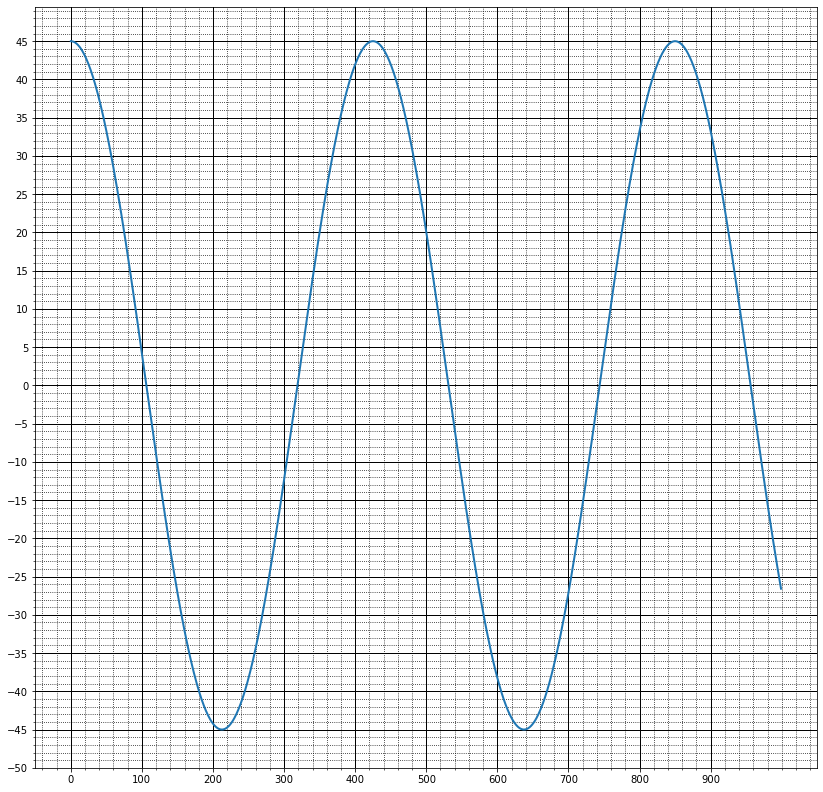

In [53]:
draw_signal(test_data['task2']['a'])

In [54]:
# YOUR CODE HERE
# Анализ сигнала a
signal_a = test_data['task2']['a']
print(f"Длина сигнала: {len(signal_a)}")
print(f"Минимальное значение: {signal_a.min()}")
print(f"Максимальное значение: {signal_a.max()}")
print(f"Амплитуда: {(signal_a.max() - signal_a.min())/2}")


Длина сигнала: 1000
Минимальное значение: -44.99877057390805
Максимальное значение: 45.0
Амплитуда: 44.99938528695402


Период сигнала = 420
Амплитуда = 45
фаза = 0

In [55]:
period = 420       # период сигнала
amplitude = 45     # амплитуда
phase = 0        # фаза
signal_length = 1000  # длина сигнала
frequency = 2 * np.pi / period

In [56]:
# Создание массива времени длиной 1000 точек
t = np.arange(signal_length)

# Генерация синусоидального сигнала
a = amplitude * np.cos(frequency * t + phase)


In [57]:
frequency

0.014959965017094254

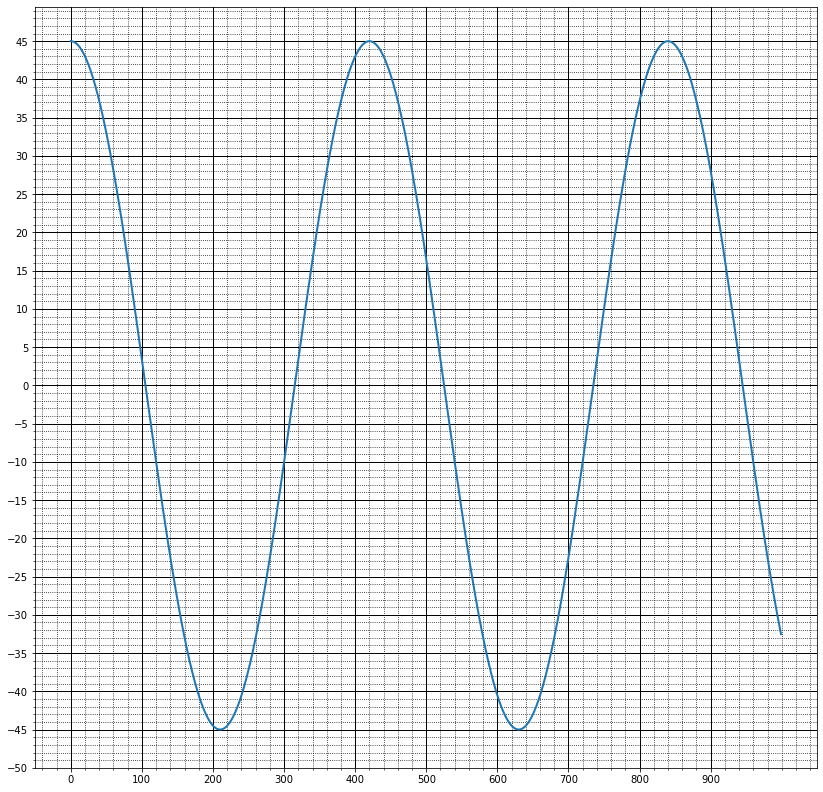

In [58]:
draw_signal(a)

In [59]:
assert len(a) == 1000
assert np.allclose(a, test_data["task2"]["a"], atol=1)
print("Ok!")

AssertionError: 

**Подобранные коэффициенты для сигнала 'a':**

1. Амплитуда - $A= $45

2. Угловая частота ($ \displaystyle\omega =\frac{2\pi}{T}) = $0,15 рад/отсчет

3. Фаза - $\phi= $0

### Сигнал ***b***

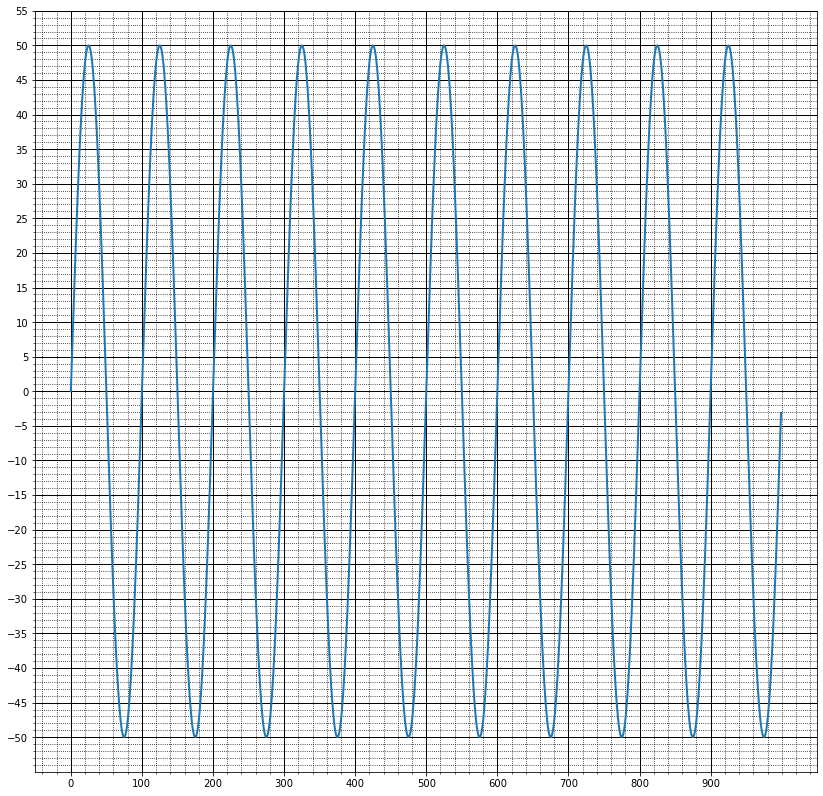

In [60]:
draw_signal(test_data['task2']['b'])

In [61]:
period = 100     # период сигнала
amplitude = 50   # амплитуда
phase = 25     # фаза
signal_length = 1000  # длина сигнала
frequency = 2 * np.pi / period

In [62]:
frequency #рад/отсчет

0.06283185307179587

In [63]:
# YOUR CODE HERE

# Создание массива времени длиной 1000 точек
t = np.arange(signal_length)

# Генерация синусоидального сигнала
b = amplitude * np.sin(frequency * t + phase)

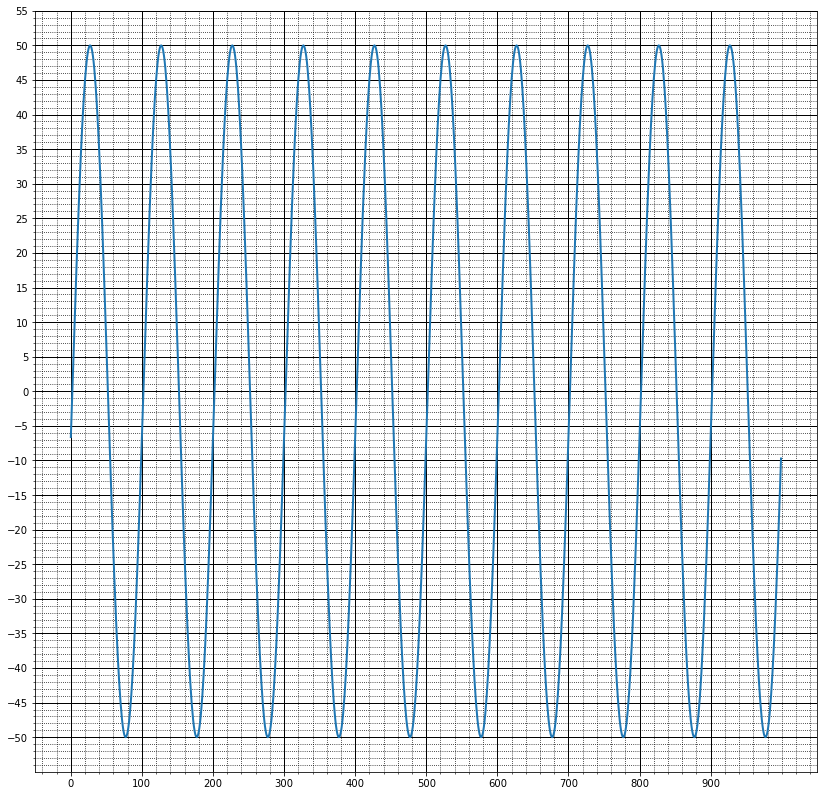

In [64]:
draw_signal(b)

In [65]:
assert len(b)== 1000
assert np.allclose(b, test_data["task2"]["b"], atol=1)
print("Ok!")

AssertionError: 

**Подобранные коэффициенты для сигнала 'b':**

1. Амплитуда - $A= $50

2. Угловая частота ($ \displaystyle\omega =\frac{2\pi}{T}) = $0,063

3. Фаза - $\phi= $25

### Сигнал ***c***

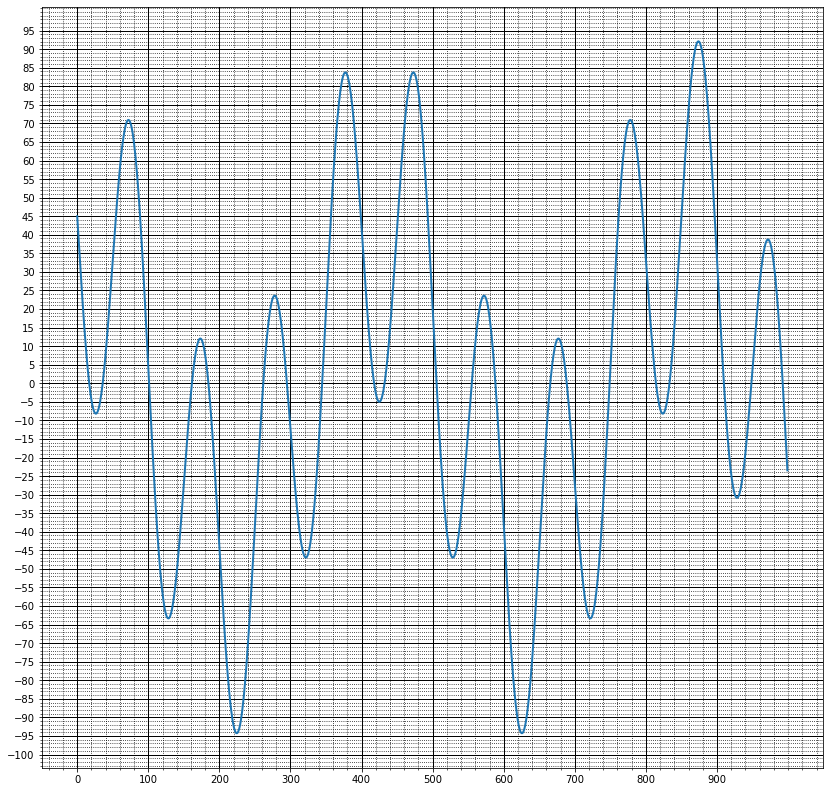

In [66]:
draw_signal(test_data['task2']['c'])

In [67]:
period1 = 420       # период сигнала
amplitude1 = 45     # амплитуда
phase1 = 0        # фаза
signal_length = 1000  # длина сигнала
frequency1 = 2 * np.pi / period

In [68]:
period2 = 100     # период сигнала
amplitude2 = 50   # амплитуда
phase2 = 25     # фаза
signal_length = 1000  # длина сигнала
frequency2 = 2 * np.pi / period

In [75]:
# Создание массива времени длиной 1000 точек
t = np.arange(signal_length)
c = amplitude1 * np.sin(frequency1 * t + phase1) + amplitude2 * np.cos(frequency2 * t + phase2)

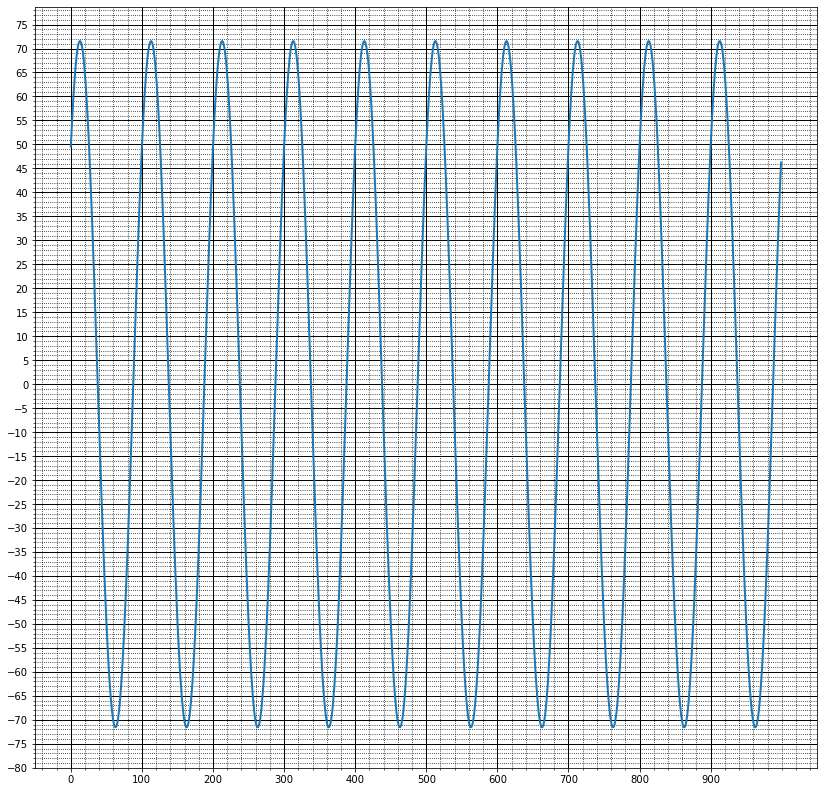

In [76]:
draw_signal(c)

In [ ]:
assert len(c)== 1000
assert np.allclose(c, test_data["task2"]["c"], atol=1)
print("Ok!")

# Задание 3. Свертка (3 балла)

## Теория
Одна из наиболее частых операций, которая выполняется при обработке сигналов, это свёртка. Свёртка имеет много различных применений, например, с ее помощью можно убрать из сигнала шумы или применить к сигналу эффект эхо.


Свёртка — это математическая операция, применённая к двум функциям f и g и порождающая третью функцию. Операцию свёртки можно интерпретировать как «схожесть» одной функции с отражённой и сдвинутой копией другой.  Другими словами, преобразование свёртки однозначно определяет выходной сигнал y(t) для установленного значения входного сигнала x(t) при известном значении функции импульсного отклика системы h(t).

<!-- ![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution") -->
![Convolution](resources/Convolution_of_box_signal_with_itself2.gif "Convolution")

Формула свёртки:
$$y_t=\frac{1}{2} \int_0^T x(\tau)h(t-τ)dτ$$
где $\tau$  - длительность импульсной переходной характеристики.

## Практика
Реализуйте операцию свёртки. Сравните её с существующей реализацией scipy.signal.convolve. Постройте графики фильтра, исходного сигнала и результата свертки.

In [103]:
from scipy.signal import convolve as scipy_convolve

SyntaxError: invalid syntax (<ipython-input-103-58769b41ad38>, line 1)

In [92]:
a = np.repeat([0,1,0], 10)
b = np.array([0,1,2,3,2,1,0])

In [93]:
def convolve(in1, in2):
    in1 = np.array(in1)
    in2 = np.array(in2)
    
    result_length = len(in1) + len(in2) - 1
    result = np.zeros(result_length)
    
    for n in range(result_length):
        for k in range(len(in1)):
            if 0 <= n - k < len(in2):
                result[n] += in1[k] * in2[n - k]
    
    return result

In [122]:
my_result = convolve(a, b)

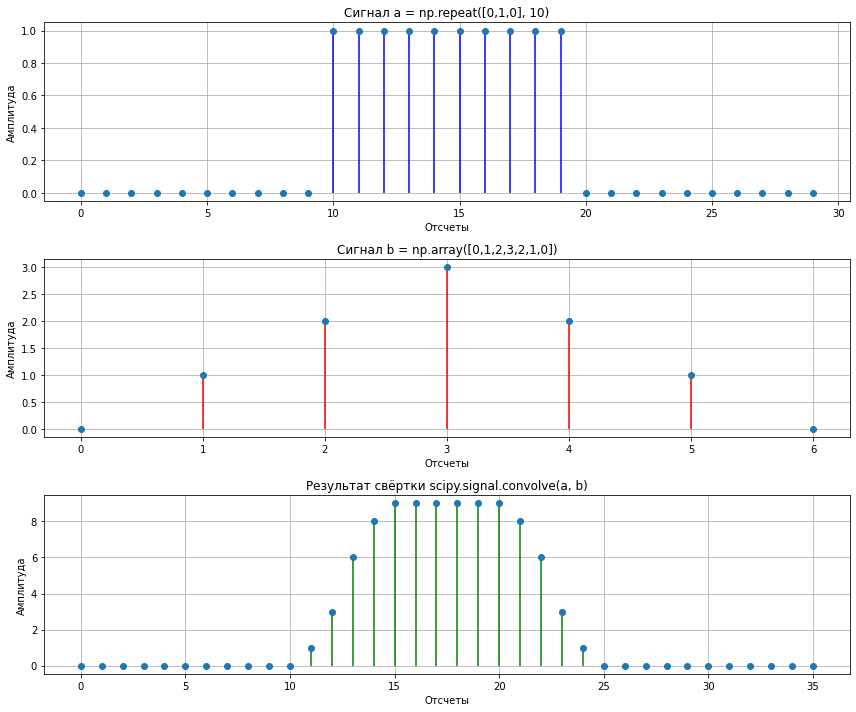

Сигнал a: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
Сигнал b: [0 1 2 3 2 1 0]
Длина сигнала a: 30
Длина сигнала b: 7
Длина результата свёртки: 36
Результат свёртки: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 3. 6. 8. 9. 9. 9. 9. 9. 9. 8. 6. 3.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [123]:
plt.figure(figsize=(12, 10))

# График 1: Сигнал a
plt.subplot(3, 1, 1)
plt.stem(np.arange(len(a)), a, 'b-', basefmt=" ")
plt.title('Сигнал a = np.repeat([0,1,0], 10)')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

# График 2: Сигнал b
plt.subplot(3, 1, 2)
plt.stem(np.arange(len(b)), b, 'r-', basefmt=" ")
plt.title('Сигнал b = np.array([0,1,2,3,2,1,0])')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

# График 3: Результат свёртки
plt.subplot(3, 1, 3)
plt.stem(np.arange(len(result)), result, 'g-', basefmt=" ")
plt.title('Результат свёртки scipy.signal.convolve(a, b)')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

plt.tight_layout()
plt.show()

# Выводим информацию о сигналах
print(f"Сигнал a: {a}")
print(f"Сигнал b: {b}")
print(f"Длина сигнала a: {len(a)}")
print(f"Длина сигнала b: {len(b)}")
print(f"Длина результата свёртки: {len(result)}")
print(f"Результат свёртки: {result}")

In [124]:
def test_convolve(a, b, print_debug=False):
    my_result = convolve(a, b)
    scipy_result = scipy_convolve(a, b, method='direct')
    if print_debug:
        print(f"Your result {my_result}")
        print(f"Scipy result {scipy_result}")
    assert np.allclose(my_result, scipy_result), f"Test {a} conv {b} failed"
    print("Ok!")
    
    

In [125]:
scipy_result = test_convolve(a, b, print_debug=False)

Ok!


In [126]:
plt.figure(figsize=(12, 8))

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

### Нарисуйте результат свертки a и b

Сигнал **а**

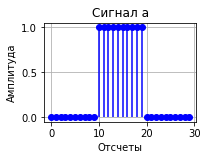

In [127]:
# Сигнал a
plt.subplot(2, 2, 1)
plt.stem(np.arange(len(a)), a, 'b-', basefmt=" ", linefmt='b-', markerfmt='bo')
plt.title('Сигнал a')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

Сигнал **b**

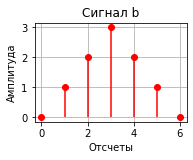

In [128]:
# График 2: Сигнал b
plt.subplot(2, 2, 2)
plt.stem(np.arange(len(b)), b, 'r-', basefmt=" ", linefmt='r-', markerfmt='ro')
plt.title('Сигнал b')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

Свертка **a** и **b**

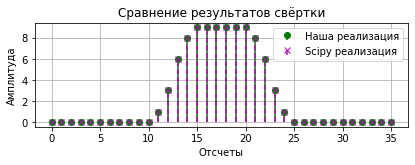

In [131]:
# График 3: Сравнение результатов
plt.subplot(2, 1, 2)
x_my = np.arange(len(my_result))
x_scipy = np.arange(len(scipy_result))

plt.stem(x_my, my_result, 'g-', basefmt=" ", linefmt='g-', markerfmt='go', label='Наша реализация')
plt.stem(x_scipy, scipy_result, 'm--', basefmt=" ", linefmt='m--', markerfmt='mx', label='Scipy реализация')
plt.title('Сравнение результатов свёртки')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Все 3 графика на одной картинке:

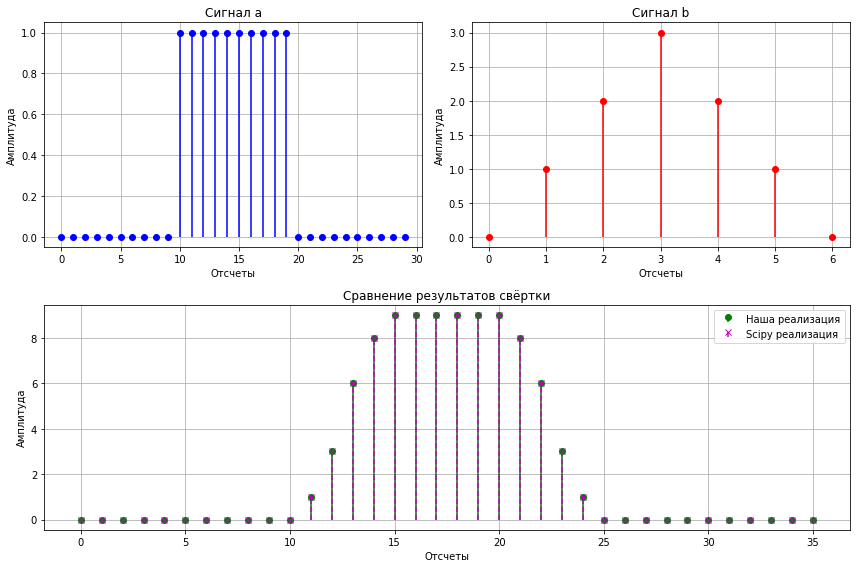

In [132]:
# Все 3 графика на одной картинке
plt.figure(figsize=(12, 8))

# График 1: Сигнал a (левый верхний)
plt.subplot(2, 2, 1)
plt.stem(np.arange(len(a)), a, 'b-', basefmt=" ", linefmt='b-', markerfmt='bo')
plt.title('Сигнал a')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

# График 2: Сигнал b (правый верхний)
plt.subplot(2, 2, 2)
plt.stem(np.arange(len(b)), b, 'r-', basefmt=" ", linefmt='r-', markerfmt='ro')
plt.title('Сигнал b')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.grid(True)

# График 3: Сравнение результатов (нижний, занимает всю ширину)
plt.subplot(2, 1, 2)
x_my = np.arange(len(my_result))
x_scipy = np.arange(len(scipy_result))

plt.stem(x_my, my_result, 'g-', basefmt=" ", linefmt='g-', markerfmt='go', label='Наша реализация')
plt.stem(x_scipy, scipy_result, 'm--', basefmt=" ", linefmt='m--', markerfmt='mx', label='Scipy реализация')
plt.title('Сравнение результатов свёртки')
plt.xlabel('Отсчеты')
plt.ylabel('Амплитуда')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Задание 4. * Алгоритм Карплуса-Стронга 

Реализуйте  [Алгоритм Карплуса-Стронга](https://en.wikipedia.org/wiki/Karplus%E2%80%93Strong_string_synthesis). В качестве фильтра используйте усреднитель двух смежных отсчетов. Проверьте результат. 

Отрисуйте и воспроизведите полученный сигнал. На что влияют параметры генерации? Попробуйте имитировать звучание разных струн гитары.

In [ ]:
def karplus_strong(noise, N):
    # Noise - input
    # N - number of samples to generate
    # return y - generated signal based on Noise 
    # YOUR CODE HERE

   

    raise NotImplementedError()

In [ ]:
np.random.seed(seed=1)
sample_rate = 44100 
frequency = 82.41
sec = 2
gen_len = sample_rate * sec
noise = (2 * np.random.uniform(-1, 1, int(sample_rate/frequency))) # [-1, 1]

gen_wav = karplus_strong(noise, gen_len)
assert np.allclose(gen_wav[:len(noise)], noise), "Generated signal must starting with noise"
assert np.allclose(gen_wav[len(noise)], (noise[0])/2), "Out of range samples eq 0."
assert np.allclose(gen_wav[len(noise)+1: 2*len(noise)], (noise[:-1] + noise[1:])/2), \
    "Bad requrent rule( 1 iteration)"
assert np.allclose(gen_wav[2*len(noise)], (noise[0]/2 + noise[-1])/2), \
    "Bad requrent rule( 2 iteration)"
assert np.allclose(gen_wav[2*len(noise)+2: 3*len(noise)], \
                   (((noise[:-1] + noise[1:])/2)[:-1] + ((noise[:-1] + noise[1:])/2)[1:])/2), \
    "Bad requrent rule( 3 iteration)"
print('All Ok!')

### Попробуем покрутить параметры генерации

Сгенерируем гитарные ноты:

In [ ]:
# YOUR CODE HERE

Визуализируем затухание амплитуды:

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel('n', fontsize=14)
plt.ylabel('Амплитуда', fontsize=14)
plt.xlim(0, gen_len)
plt.plot(np.linspace(0, gen_len+1, gen_len), gen_wav)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()

Визуализируйте затухание амплитуд гитарных нот:

In [ ]:
# YOUR CODE HERE